In [1]:
from data_prep import *
from tools import *

In [2]:
data = read_hdf5_file("data/2025-07-04.h5")
data_old = read_hdf5_file("data/2025_07_04_24h.h5")
print(data.keys())

data_sirta = data['IPRAL']
data_atlid_l1 = data['ATLID_L1_300km']
data_atlid_l2 = data['ATLID_L2_300km']



<KeysViewHDF5 ['ATLID_L1_300km', 'ATLID_L2_300km', 'IPRAL']>


In [3]:

time_sirta= np.array(days_since_1970_to_datetime(data_sirta["time"]))
alt_sirta = np.array(data_sirta["range"])

In [4]:
rcs_12_rc = get_corrected_signal( data_sirta , alt_sirta ,rcs_="rcs_12")
rcs_02_rc = get_corrected_signal( data_sirta , alt_sirta ,rcs_="rcs_02")
rcs_03_rc = get_corrected_signal( data_sirta , alt_sirta ,rcs_="rcs_03")
rcs_04_rc = get_corrected_signal( data_sirta , alt_sirta ,rcs_="rcs_04")
rcs_05_rc = get_corrected_signal( data_sirta , alt_sirta ,rcs_="rcs_05")

print(np.shape(rcs_12_rc))
print(np.shape(time_sirta))
print(np.shape(alt_sirta))

(2428, 4000)
(2428,)
(4000,)


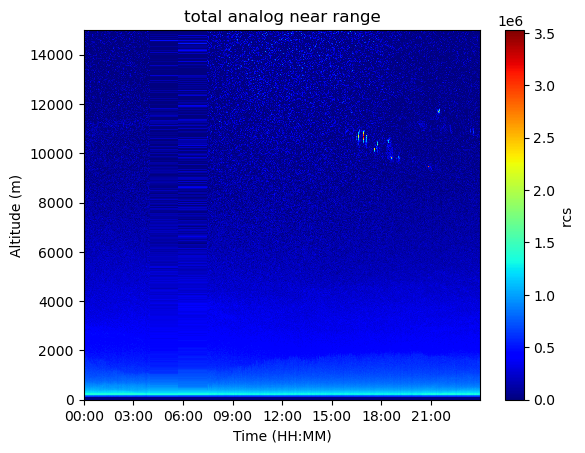

In [5]:
vmax= np.percentile(rcs_12_rc , 97)
plot_rcs(rcs_12_rc , time_sirta , alt_sirta , "total analog near range" , vmax=vmax , vmin=0 , near_range = True, save=True) 


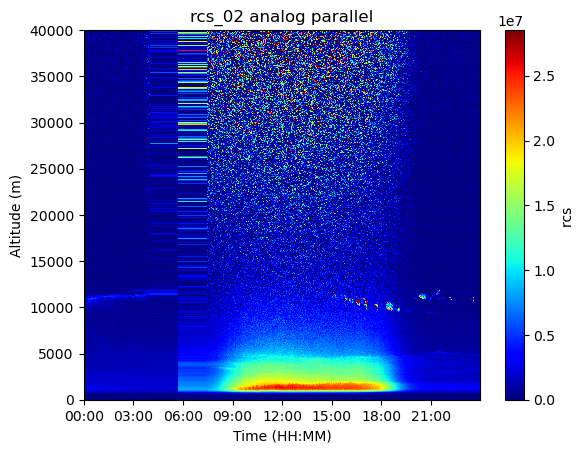

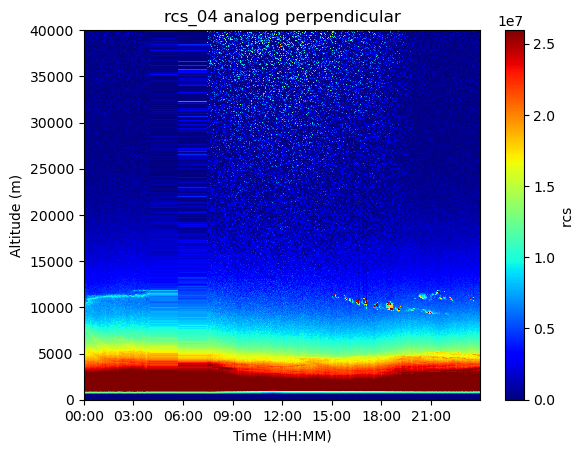

In [6]:

vmax= np.percentile(rcs_02_rc , 97)
plot_rcs(rcs_02_rc , time_sirta , alt_sirta , "rcs_02 analog parallel" , vmax=vmax , vmin=0 , near_range = False)  
vmax= np.percentile(rcs_04_rc , 97)
plot_rcs(rcs_04_rc , time_sirta , alt_sirta , "rcs_04 analog perpendicular" , vmax=vmax , vmin=0 , near_range = False) 

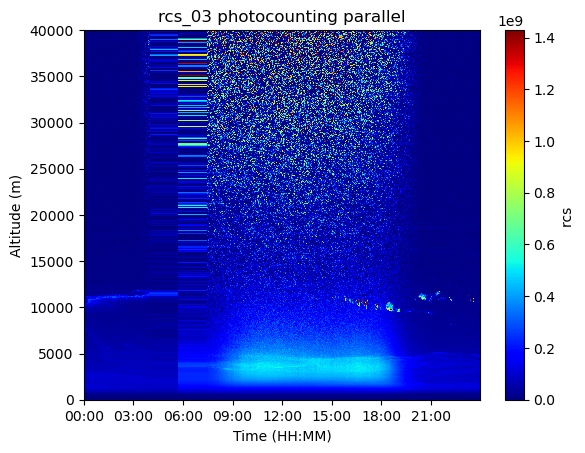

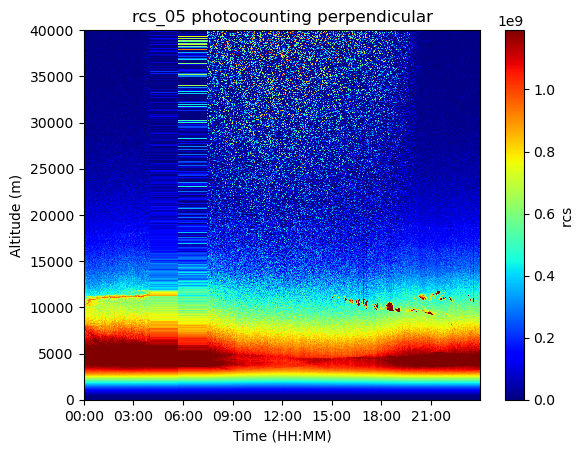

In [7]:

vmax= np.percentile(rcs_03_rc , 97)
plot_rcs(rcs_03_rc , time_sirta , alt_sirta , "rcs_03 photocounting parallel" , vmax=vmax , vmin=0 , near_range = False)  


vmax= np.percentile(rcs_05_rc , 97)
plot_rcs(rcs_05_rc , time_sirta , alt_sirta , "rcs_05 photocounting perpendicular" , vmax=vmax , vmin=0 , near_range = False) 

In [8]:
start_time_clear='2025-07-04T22:30:00'
end_time_clear='2025-07-04T23:00:00'
index_clear =np.array( get_indx_from_range_time_sirta(start_time_clear , end_time_clear , time_sirta))

In [9]:

rs_file = "data/rs_2a_GRUAN_TRP_M10_20250704_231547_v2.0.1.nc"
conc , alt_rs  = conc_calculation (rs_file)

# plt.plot(conc, alt_rs)
# plt.title("conc")

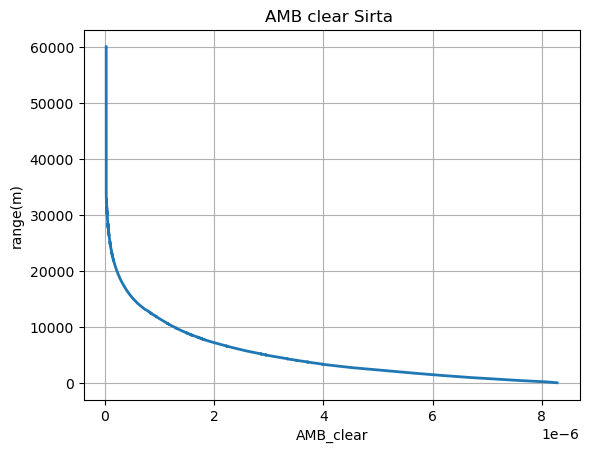

In [10]:
depolarization_ratio = 0.014

AMB_clear  , beta_ray , alpha_ray =  calculate_AMB_clear( conc, alt_rs, alt_sirta  )
AMB_clear_parallel = AMB_clear *  (1-depolarization_ratio)
AMB_clear_perpendicular = AMB_clear * depolarization_ratio

plt.title("AMB clear Sirta ")
plt.plot(AMB_clear , alt_sirta , linewidth = 2)
plt.ylabel("range(m)")
plt.xlabel("AMB_clear")
plt.grid(True)
plt.savefig("figures/AMB_clear_sirta.png")


### calibration for analog 

In [11]:
analog_parallel_clear=np.nanmean( rcs_02_rc[index_clear , :] , axis=0 )
analog_perpendicular_clear= np.nanmean( rcs_04_rc[index_clear , :] , axis=0 )


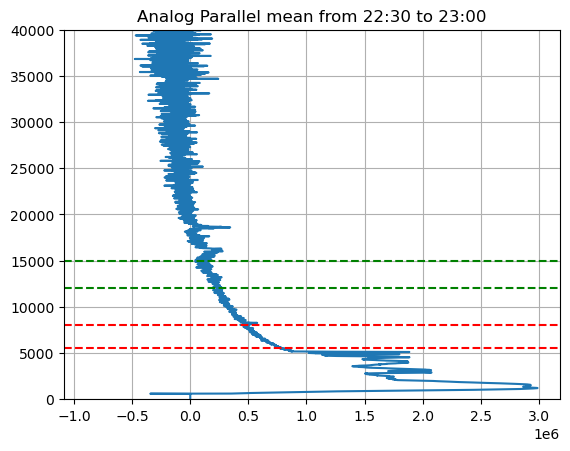

In [12]:



mask1_analog_par=[5500 , 8000]
mask2_analog_par=[12000 , 15000]


plt.figure()
plt.title(f"Analog Parallel mean from {start_time_clear[11:16]} to {end_time_clear[11:16]}")
plt.plot(analog_parallel_clear , alt_sirta)
plt.axhline(y=mask1_analog_par[0], color='r', linestyle='--')
plt.axhline(y=mask1_analog_par[1], color='r', linestyle='--' )
plt.axhline(y=mask2_analog_par[0], color='g', linestyle='--')
plt.axhline(y=mask2_analog_par[1], color='g', linestyle='--')
plt.ylim(0 , 40000)
plt.grid(True)

plt.savefig("figures/Analog_Parallel_clear.png")


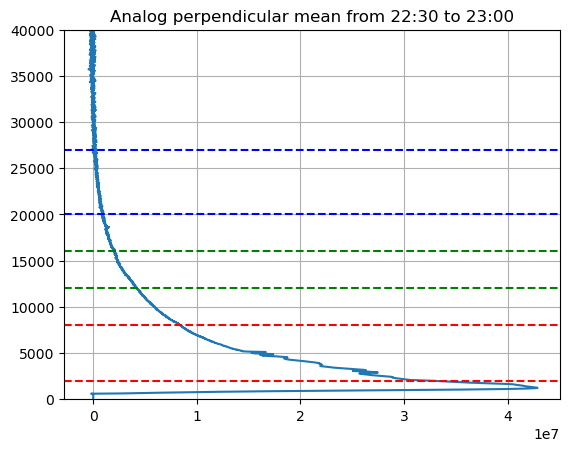

In [13]:
mask1_analog_per=[2000 , 8000]
mask2_analog_per=[12000 , 16000]
mask3_analog_per=[20000 , 27000]



plt.figure()
plt.title(f"Analog perpendicular mean from {start_time_clear[11:16]} to {end_time_clear[11:16]}")
plt.plot(analog_perpendicular_clear , alt_sirta)

plt.axhline(y=mask1_analog_per[0], color='r', linestyle='--')
plt.axhline(y=mask1_analog_per[1], color='r', linestyle='--' )
plt.axhline(y=mask2_analog_per[0], color='g', linestyle='--')
plt.axhline(y=mask2_analog_per[1], color='g', linestyle='--')
plt.axhline(y=mask3_analog_per[0], color='b', linestyle='--')
plt.axhline(y=mask3_analog_per[1], color='b', linestyle='--')   

plt.ylim(0 , 40000)
plt.grid(True)
plt.savefig("figures/Analog_Perpendicular_clear.png")   

In [14]:
K_0_an_par , delta_0_an_par =Calibration(analog_parallel_clear , AMB_clear_parallel , alt_sirta ,  mask1_analog_par , mask2_analog_par , visual=False ) 

K_analog_par, delta_analog_par, result = optimize(analog_parallel_clear, AMB_clear_parallel, alt_sirta,[mask1_analog_par, mask2_analog_par , mask2_analog_par],K_0_an_par, delta_0_an_par ,  method='Nelder-Mead')
ATB_analog_par = K_analog_par * (analog_parallel_clear - delta_analog_par)

print("initiale K:", K_0_an_par, "delta:", delta_0_an_par)
print("optimized K:", K_analog_par, "delta:", delta_analog_par)

initiale K: 3.374696910328535e-12 delta: -29939.07397498052
optimized K: 3.264534109352619e-12 delta: -40939.58764408561


In [15]:
K_0_an_per , delta_0_an_per =Calibration(analog_perpendicular_clear , AMB_clear_perpendicular , alt_sirta ,  mask1_analog_per , mask2_analog_per , visual=False ) 
K_analog_per, delta_analog_per, result = optimize(analog_perpendicular_clear, AMB_clear_perpendicular, alt_sirta,[mask1_analog_per, mask2_analog_per , mask3_analog_per],K_0_an_per, delta_0_an_per ,  method='Nelder-Mead')
ATB_analog_per = K_analog_per * (analog_perpendicular_clear - delta_analog_per)

print("initiale K:", K_0_an_per, "delta:", delta_0_an_per)
print("optimized K:", K_analog_per, "delta:", delta_analog_per)

initiale K: 2.5286429843640845e-15 delta: -658606.686395763
optimized K: 2.7916722349124387e-15 delta: -180562.89302216488


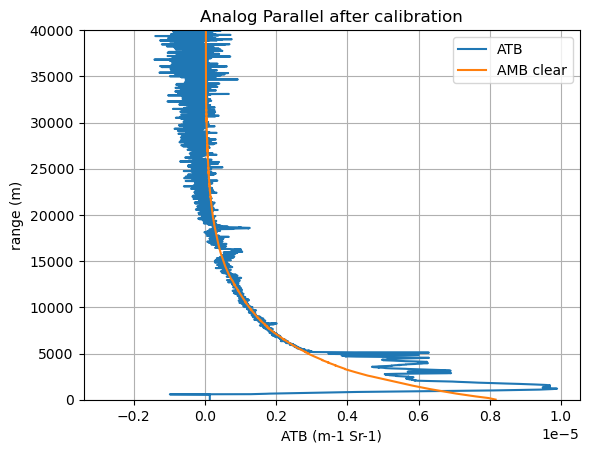

In [16]:
plt.figure()
plt.title("Analog Parallel after calibration")  

plt.plot(ATB_analog_par , alt_sirta , label="ATB")
plt.plot(AMB_clear_parallel , alt_sirta , label="AMB clear")
plt.ylim((0, 40000))
plt.grid(True)
plt.xlabel("ATB (m-1 Sr-1)")
plt.ylabel("range (m)")
plt.legend()
plt.savefig("figures/Analog_Parallel_after_calibration.png")



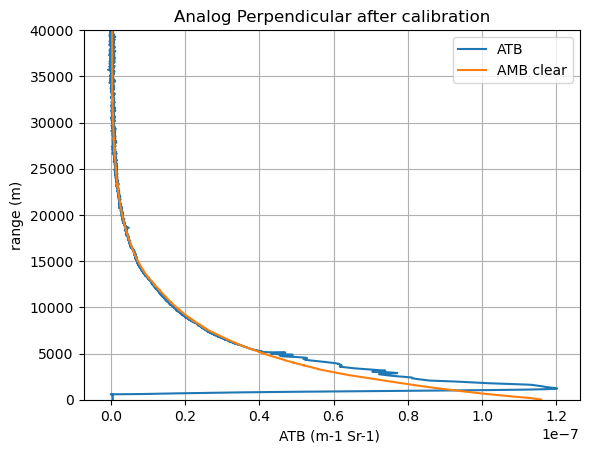

In [17]:
plt.figure()
plt.plot(ATB_analog_per , alt_sirta, label="ATB")
plt.plot(AMB_clear_perpendicular , alt_sirta, label="AMB clear")
plt.ylim((0, 40000))
plt.grid(True)
plt.title("Analog Perpendicular after calibration")
plt.xlabel("ATB (m-1 Sr-1) ")
plt.ylabel("range (m)")
plt.legend()
plt.savefig("figures/Analog_Perpendicular_after_calibration.png")



### calibration for photocounting

In [18]:
photocounting_parallel_clear=np.nanmean( rcs_03_rc[index_clear , :] , axis=0 )
photocounting_perpendicular_clear= np.nanmean( rcs_05_rc[index_clear , :] , axis=0 )


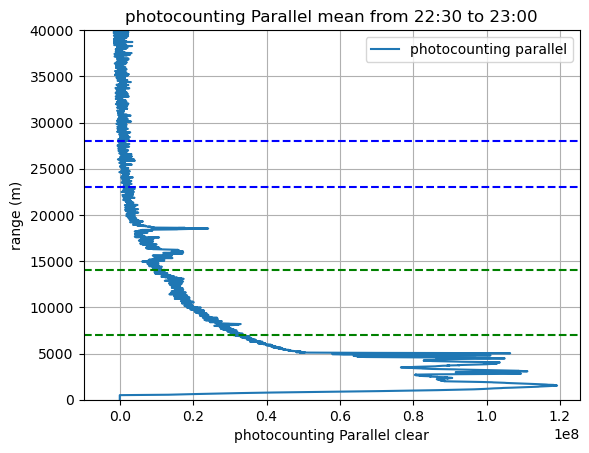

In [19]:


# mask1_photo_par=[30000 , 35000]
mask2_photo_par=[7000 , 14000]
mask3_photo_par=[23000 , 28000]



plt.figure()
plt.title(f"photocounting Parallel mean from {start_time_clear[11:16]} to {end_time_clear[11:16]}")
plt.plot(photocounting_parallel_clear , alt_sirta, label="photocounting parallel")
plt.axhline(y=mask2_photo_par[0], color='g', linestyle='--')
plt.axhline(y=mask2_photo_par[1], color='g', linestyle='--')
plt.axhline(y=mask3_photo_par[0], color='b', linestyle='--')
plt.axhline(y=mask3_photo_par[1], color='b', linestyle='--')
plt.ylim(0 , 40000)
plt.grid(True)
plt.xlabel("photocounting Parallel clear")
plt.ylabel("range (m)")
plt.legend()
plt.savefig("figures/Photocounting_Parallel_clear.png")




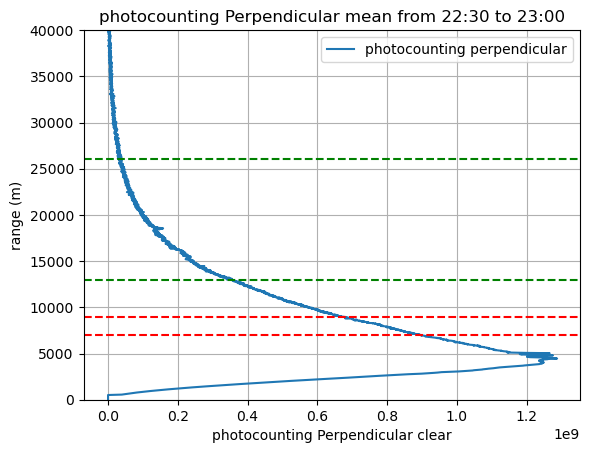

In [20]:

mask1_photo_per=[7000 , 9000]
mask2_photo_per=[13000 , 26000]


plt.figure()
plt.title(f"photocounting Perpendicular mean from {start_time_clear[11:16]} to {end_time_clear[11:16]}")
plt.plot(photocounting_perpendicular_clear , alt_sirta, label="photocounting perpendicular")
plt.axhline(y=mask1_photo_per[0], color='r', linestyle='--')
plt.axhline(y=mask1_photo_per[1], color='r', linestyle='--' )
plt.axhline(y=mask2_photo_per[0], color='g', linestyle='--')
plt.axhline(y=mask2_photo_per[1], color='g', linestyle='--')
plt.ylim(0 , 40000)
plt.grid(True)
plt.xlabel("photocounting Perpendicular clear")
plt.ylabel("range (m)")
plt.legend()
plt.savefig("figures/Photocounting_Perpendicular_clear.png")




In [21]:
K_0_ph_par , delta_0_ph_par =Calibration(photocounting_parallel_clear , AMB_clear_parallel , alt_sirta ,  mask2_photo_par , mask3_photo_par , visual=False ) 

K_ph_par, delta_ph_par, result = optimize(photocounting_parallel_clear, AMB_clear_parallel, alt_sirta,[ mask2_photo_par , mask3_photo_par],K_0_ph_par, delta_0_ph_par ,  method='Nelder-Mead')

ATB_ph_par = K_ph_par * (photocounting_parallel_clear - delta_ph_par)

print("initiale K:", K_0_ph_par, "delta:", delta_0_ph_par)
print("optimized K:", K_ph_par, "delta:", delta_ph_par)

initiale K: 6.007676363137647e-14 delta: -286254.1199494223
optimized K: 5.675499505944254e-14 delta: -401705.79278602975


In [22]:
K_0_ph_per , delta_0_ph_per =Calibration(photocounting_perpendicular_clear , AMB_clear_perpendicular , alt_sirta ,  mask1_photo_per , mask2_photo_per , visual=False ) 

K_ph_per, delta_ph_per, result = optimize(photocounting_perpendicular_clear, AMB_clear_perpendicular, alt_sirta,[mask1_photo_per, mask2_photo_per , mask2_photo_per],K_0_ph_per, delta_0_ph_per ,  method='Nelder-Mead')

ATB_ph_per = K_ph_per * (photocounting_perpendicular_clear - delta_ph_per)

print("initiale K:", K_0_ph_per, "delta:", delta_0_ph_per)
print("optimized K:", K_ph_per, "delta:", delta_ph_per)

initiale K: 3.152237066812075e-17 delta: 7173099.796427655
optimized K: 3.0233622395859453e-17 delta: -1857910.2087344392


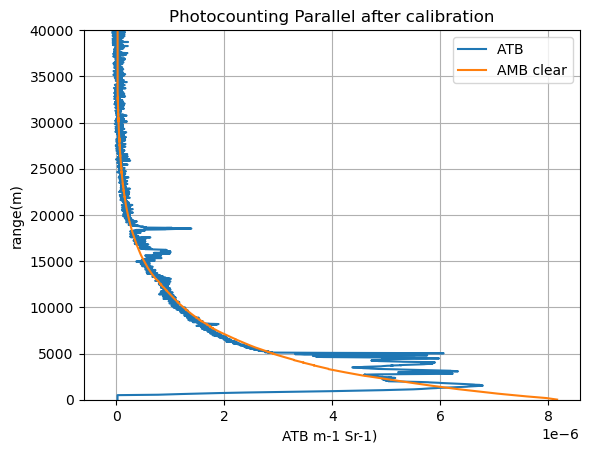

In [23]:
plt.figure()
plt.title("Photocounting Parallel after calibration")   
plt.plot(ATB_ph_par , alt_sirta, label="ATB ")
plt.plot(AMB_clear_parallel , alt_sirta, label="AMB clear")
plt.grid(True)
plt.ylabel("range(m)")
plt.xlabel("ATB m-1 Sr-1) ")
plt.legend()
plt.ylim((0,40000))
plt.savefig("figures/Photocounting_Parallel_after_calibration.png")


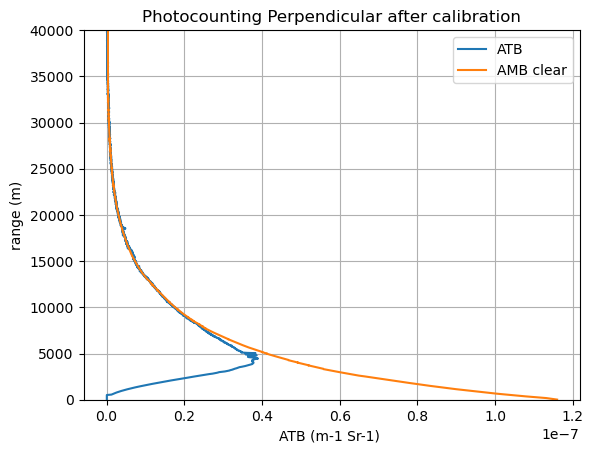

In [24]:
plt.figure()
plt.title("Photocounting Perpendicular after calibration")
plt.plot(ATB_ph_per , alt_sirta, label="ATB")
plt.plot(AMB_clear_perpendicular , alt_sirta, label="AMB clear")
plt.grid(True)
plt.xlabel("ATB (m-1 Sr-1) ")
plt.ylabel("range (m)")
plt.legend()
plt.ylim((0,40000))
plt.savefig("figures/Photocounting_Perpendicular_after_calibration.png")


### coller parallel 

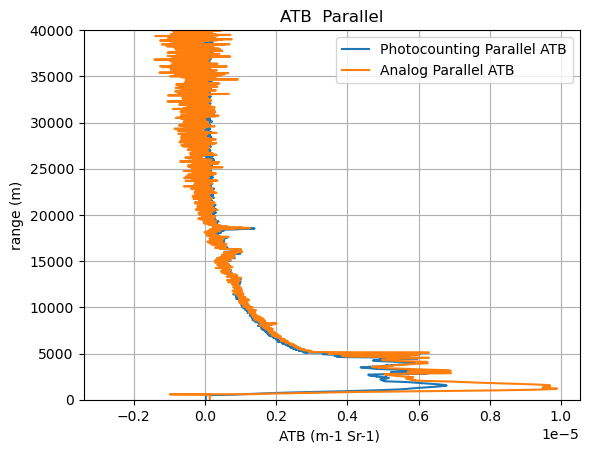

In [25]:
plt.figure()
plt.title("ATB  Parallel")
plt.plot(ATB_ph_par , alt_sirta , label='Photocounting Parallel ATB')
plt.plot(ATB_analog_par , alt_sirta , label='Analog Parallel ATB')
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1) ")
plt.ylabel("range (m)")
plt.legend()
plt.grid(True)

plt.savefig("figures/Photocounting_Parallel_after_calibration.png")


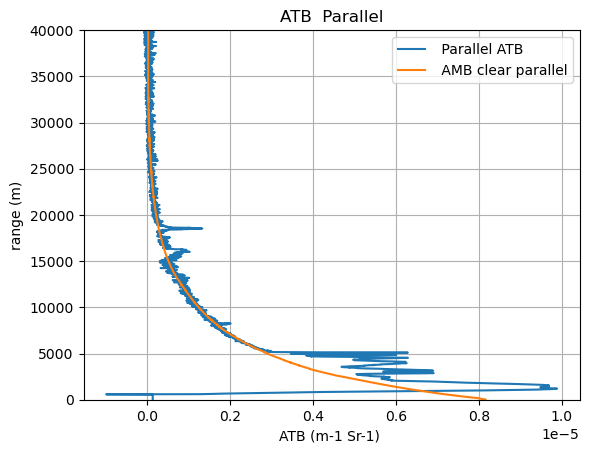

In [26]:
ATB_par = merged_signal_hanning(ATB_analog_par, ATB_ph_par, alt_sirta, transition_start=13000, transition_end=20000)

# ATB_par = correct_atb(ATB_par , AMB_clear_parallel)


plt.figure()
plt.title("ATB  Parallel")
plt.plot(ATB_par , alt_sirta , label=' Parallel ATB')  
plt.plot(AMB_clear_parallel, alt_sirta , label=' AMB clear parallel' )   
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1) ")
plt.ylabel("range (m)")
plt.legend()
plt.grid(True)
plt.savefig("figures/ATB_Parallel_after_calibration.png")   

### coller perpendicular

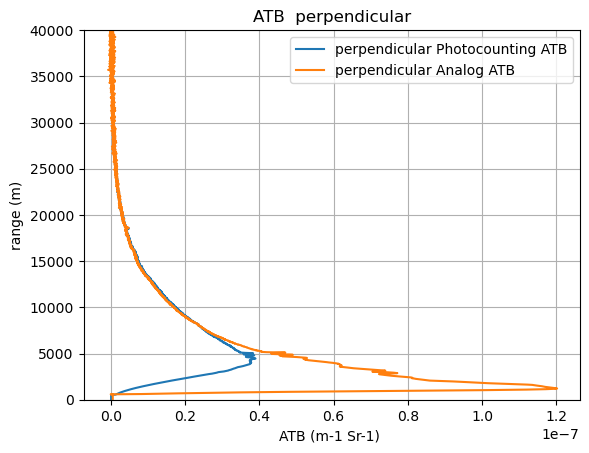

In [27]:
plt.figure()
plt.title("ATB  perpendicular")
plt.plot(ATB_ph_per, alt_sirta , label='perpendicular Photocounting ATB')
plt.plot(ATB_analog_per, alt_sirta , label='perpendicular Analog ATB')
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1) ")
plt.ylabel("range (m)")
plt.legend()
plt.grid(True)
plt.savefig("figures/ATB_Perpendicular_after_calibration.png")

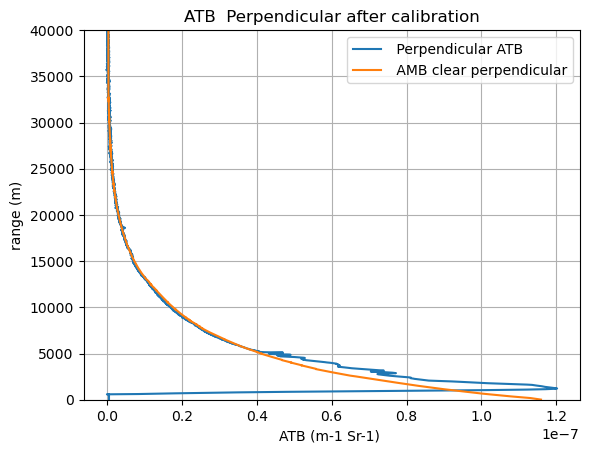

In [28]:
ATB_per = merged_signal_hanning(ATB_analog_per, ATB_ph_per, alt_sirta, transition_start=11000, transition_end=150000)
# ATB_per = correct_atb(ATB_per , AMB_clear_perpendicular)

plt.figure()
plt.title("ATB  Perpendicular after calibration")
plt.plot(ATB_per , alt_sirta , label=' Perpendicular ATB')  
plt.plot(AMB_clear_perpendicular, alt_sirta , label=' AMB clear perpendicular' )   
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1) ")

plt.ylabel("range (m)")
plt.legend()
plt.grid(True)


### perpendicular et parallel

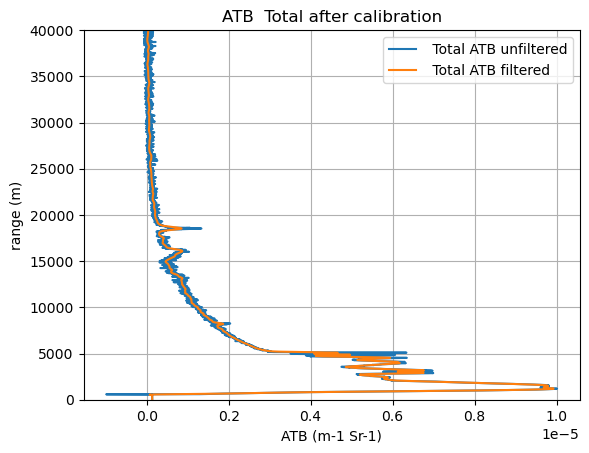

In [29]:
ATB_total= ATB_per + ATB_par 

ATB_SIRTA = gaussian_filter(ATB_total , alt_sirta , max_sigma=5  )

plt.figure()
plt.title("ATB  Total after calibration")
plt.plot(ATB_total , alt_sirta , label=' Total ATB unfiltered' )
plt.plot(ATB_SIRTA , alt_sirta , label=' Total ATB filtered')
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1)")
plt.ylabel("range (m)")
plt.legend()
plt.grid(True)

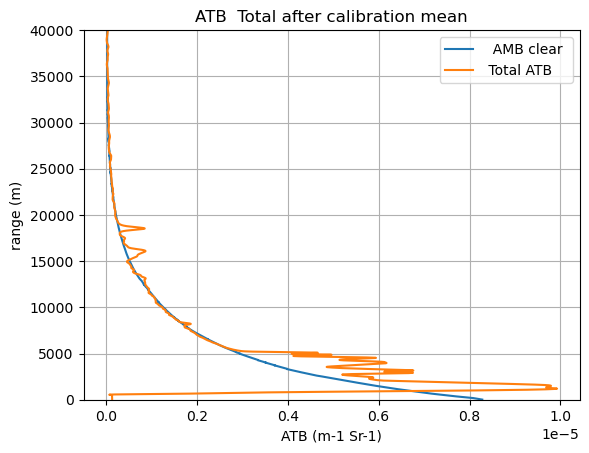

In [30]:
plt.figure()
plt.title(f"ATB  Total after calibration mean" )   
plt.plot(AMB_clear , alt_sirta , label='  AMB clear ' )
plt.plot(ATB_SIRTA , alt_sirta , label=' Total ATB ')
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1)")
plt.ylabel("range (m)")
plt.grid(True)

plt.legend()


### klett inversion

In [31]:
## take care of nan values

ATB_per= remove_nans_interpolation(ATB_per, alt_sirta)
ATB_par = remove_nans_interpolation(ATB_par, alt_sirta)
ATB_SIRTA = remove_nans_interpolation(ATB_SIRTA, alt_sirta)
AMB_clear = remove_nans_interpolation(AMB_clear, alt_sirta)
beta_ray = remove_nans_interpolation(beta_ray, alt_sirta)





calibration range 19250.0 m  to 20750.0 m


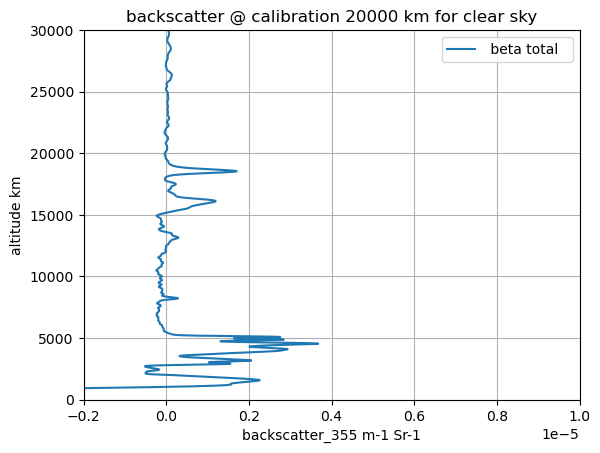

In [32]:
INDEX_FOR_THE_CALIBRATION = 20000  # in  km 

index_reference = np.argmin(np.abs(alt_sirta -INDEX_FOR_THE_CALIBRATION ))
reference_range = 50  
beta_aerosol_reference = 1e-9
bin_length = np.abs(np.median(np.diff(alt_sirta))) 
LR =20

print(f"calibration range {INDEX_FOR_THE_CALIBRATION -reference_range * bin_length } m  to {INDEX_FOR_THE_CALIBRATION + reference_range * bin_length } m")


beta_aerosol_total_clear, _ = klett_backscatter_aerosol_simplifié( ATB_SIRTA,LR,beta_ray,index_reference,reference_range,beta_aerosol_reference,bin_length,8*np.pi/3 , affiche=False)
beta_aerosol_par_clear, _ = klett_backscatter_aerosol_simplifié( ATB_par,LR,beta_ray,index_reference,reference_range,beta_aerosol_reference,bin_length,8*np.pi/3 , affiche=False)
beta_aerosol_per_clear, _ = klett_backscatter_aerosol_simplifié( ATB_per,LR,beta_ray,index_reference,reference_range,beta_aerosol_reference,bin_length,8*np.pi/3 , affiche=False)

plt.figure()
plt.plot(beta_aerosol_total_clear , alt_sirta , label = " beta total  ")
# plt.plot(beta_aerosol_par_clear , alt_sirta , label = " beta par  ")
# plt.plot(beta_aerosol_per_clear , alt_sirta , label = " beta per  ")
plt.xlabel("backscatter_355 m-1 Sr-1")
plt.ylabel("altitude km")
plt.title(f"backscatter @ calibration {INDEX_FOR_THE_CALIBRATION} km for clear sky")
plt.grid("True")
plt.legend()
plt.ylim((00,30000))
plt.xlim((-2e-6,1e-5))
plt.savefig("figures/backscatter_aerosol_clear_calibrated.png")



### cloudy sky 

In [33]:
start_time='2025-07-04T20:00:00'
end_time='2025-07-04T23:40:00'
index_cloudy =np.array( get_indx_from_range_time_sirta(start_time , end_time , time_sirta))



In [34]:
# cloudy sky

analog_parallel_cloudy=np.nanmean( rcs_02_rc[index_cloudy , :] , axis=0 )
analog_perpendicular_cloudy= np.nanmean( rcs_04_rc[index_cloudy , :] , axis=0 )

photocounting_parallel_cloudy=np.nanmean( rcs_03_rc[index_cloudy , :] , axis=0 )
photocounting_perpendicular_cloudy= np.nanmean( rcs_05_rc[index_cloudy , :] , axis=0 )


# calibration for cloudy sky

ATB_analog_par = K_analog_par * (analog_parallel_cloudy - delta_analog_par)
ATB_analog_per = K_analog_per * (analog_perpendicular_cloudy - delta_analog_per)


ATB_ph_par = K_ph_par * (photocounting_parallel_cloudy - delta_ph_par)
ATB_ph_per = K_ph_per * (photocounting_perpendicular_cloudy - delta_ph_per)


# merging signals

ATB_par = merged_signal_hanning(ATB_analog_par, ATB_ph_par, alt_sirta, transition_start=13000, transition_end=20000)
ATB_per = merged_signal_hanning(ATB_analog_per, ATB_ph_per, alt_sirta, transition_start=11000, transition_end=150000)   

ATB_total= ATB_per + ATB_par    

# nan handling

ATB_per= remove_nans_interpolation(ATB_per, alt_sirta)
ATB_par = remove_nans_interpolation(ATB_par, alt_sirta)
ATB_total = remove_nans_interpolation(ATB_total, alt_sirta)




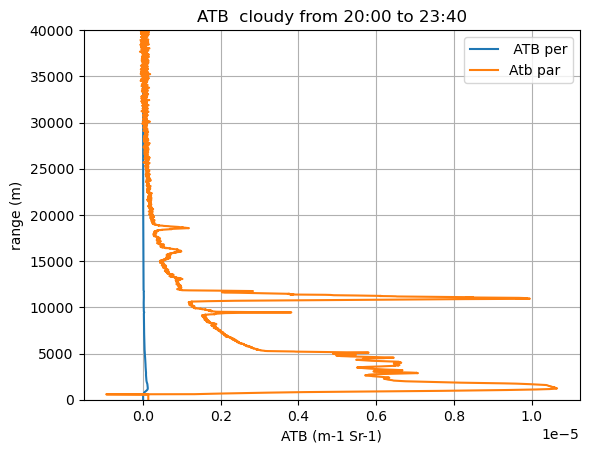

In [35]:
plt.figure()
plt.title(f"ATB  cloudy from {start_time[11:16]} to {end_time[11:16]}") 

plt.plot(ATB_per, alt_sirta, label=' ATB per')
plt.plot(ATB_par, alt_sirta, label='Atb par')
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1)")
plt.ylabel("range (m)")
plt.grid(True)
plt.legend()

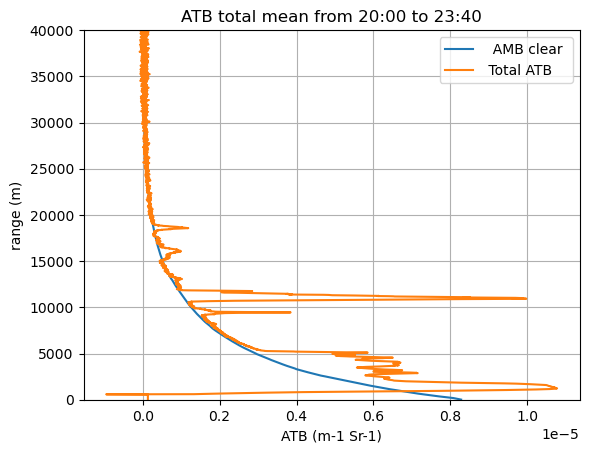

In [36]:
plt.figure()    
plt.title(f"ATB total mean from {start_time[11:16]} to {end_time[11:16]}") 
plt.plot(AMB_clear , alt_sirta , label='  AMB clear ' )
plt.plot(ATB_total , alt_sirta , label=' Total ATB ')   
plt.ylim(0 , 40000)
plt.xlabel("ATB (m-1 Sr-1)")
plt.ylabel("range (m)")
plt.grid(True)
plt.legend()    
plt.savefig("figures/ATB_total_cloudy.png")

In [37]:
INDEX_FOR_THE_CALIBRATION = 20000  # in  km 

index_reference = np.argmin(np.abs(alt_sirta -INDEX_FOR_THE_CALIBRATION ))
reference_range = 50  
beta_aerosol_reference = 1e-9
bin_length = np.abs(np.median(np.diff(alt_sirta))) 
LR =17

print(f"calibration range {INDEX_FOR_THE_CALIBRATION -reference_range * bin_length } m  to {INDEX_FOR_THE_CALIBRATION + reference_range * bin_length } m")


beta_aerosol_total_cloudy, beta_sum = klett_backscatter_aerosol_simplifié( ATB_total,LR,beta_ray,index_reference,reference_range,beta_aerosol_reference,bin_length,8*np.pi/3 , affiche=False)



calibration range 19250.0 m  to 20750.0 m


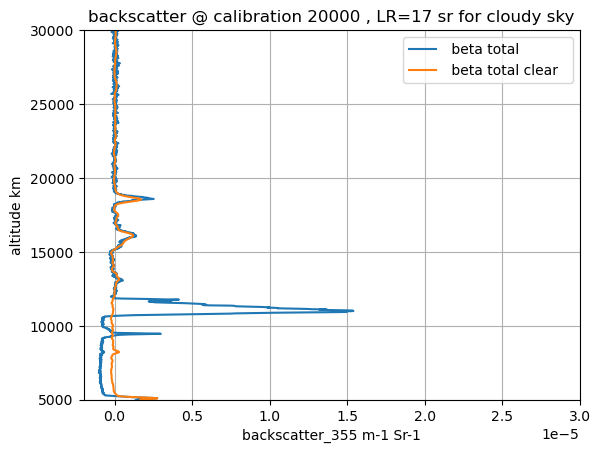

In [38]:

plt.figure()
plt.plot(beta_aerosol_total_cloudy , alt_sirta , label = " beta total  ")
plt.plot(beta_aerosol_total_clear , alt_sirta , label = " beta total clear  ")
plt.xlabel("backscatter_355 m-1 Sr-1")
plt.ylabel("altitude km")
plt.title(f"backscatter @ calibration {INDEX_FOR_THE_CALIBRATION} , LR={LR} sr for cloudy sky")
plt.grid("True")
plt.legend()
plt.ylim((5000,30000))
plt.xlim((-2e-6,3e-5))
# plt.savefig("figures/backscatter_aerosol_cloudy_calibrated.png")
plt.savefig("figures/backscatter_aerosol_cloudy_vs_clear_calibrated.png")


In [39]:
min_indx_l2 = int(data_atlid_l2["min_index"][()])
interval = 150
start_idx = min_indx_l2 - interval
end_idx = min_indx_l2 + interval


backscatter_355_atlid = np.array(data_atlid_l2["particle_backscatter_coefficient_355nm"][start_idx:end_idx][:])
APB_355_atlid = np.array(data_atlid_l2["APB"][:,start_idx:end_idx])
AMB_355_atlid = np.array(data_atlid_l2["AMB"][:,start_idx:end_idx])
altitude_atlid = np.array(data_atlid_l2["height"][start_idx:end_idx][:])
print(np.shape(APB_355_atlid))


backscatter_355_atlid = np.where(backscatter_355_atlid > 1e35 , np.nan , backscatter_355_atlid)
APB_355_atlid = np.where(APB_355_atlid > 1e34 , np.nan , APB_355_atlid)
AMB_355_atlid = np.where(AMB_355_atlid > 1e34 , np.nan , AMB_355_atlid)

APB_355_atlid = np.where(APB_355_atlid < 0 , np.nan , APB_355_atlid)
AMB_355_atlid = np.where(AMB_355_atlid < 0 , np.nan , AMB_355_atlid)



backscatter_355_atlid_avrg = np.nanmean(backscatter_355_atlid , axis=0)
APB_355_atlid_avrg = np.nanmean(APB_355_atlid , axis=1)
AMB_355_atlid_avrg = np.nanmean(AMB_355_atlid , axis=1)




(242, 300)


/tmp/ipykernel_29032/4095199455.py:23: RuntimeWarning: Mean of empty slice
  backscatter_355_atlid_avrg = np.nanmean(backscatter_355_atlid , axis=0)
/tmp/ipykernel_29032/4095199455.py:24: RuntimeWarning: Mean of empty slice
  APB_355_atlid_avrg = np.nanmean(APB_355_atlid , axis=1)
/tmp/ipykernel_29032/4095199455.py:25: RuntimeWarning: Mean of empty slice
  AMB_355_atlid_avrg = np.nanmean(AMB_355_atlid , axis=1)


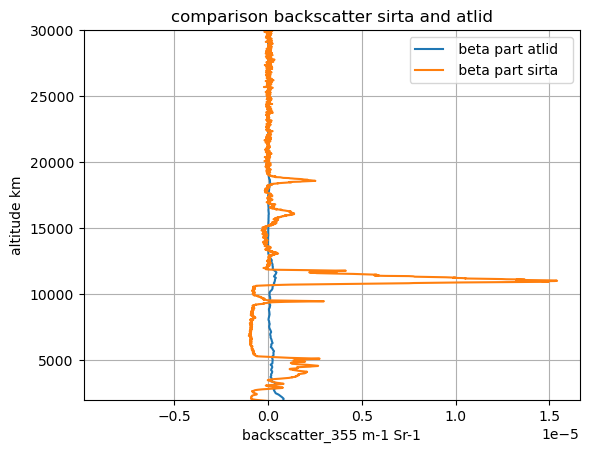

In [40]:
plt.figure()
plt.plot(backscatter_355_atlid_avrg , altitude_atlid[0 , :] , label=' beta part atlid ')
plt.plot(beta_aerosol_total_cloudy , alt_sirta , label = " beta part sirta  ")
plt.xlabel("backscatter_355 m-1 Sr-1")
plt.ylabel("altitude km")
plt.title("comparison backscatter sirta and atlid")
plt.ylim((2000,30000))
# plt.xlim((-2e-6,2e-6))
plt.grid("True")
plt.legend()    

## save the calibrated data 

In [41]:
# create dictionaries to save data

import h5py

output_file = "data/calibrated_data_2025_07_04.h5"

clear_data = {
    "time_range": {
        "start_time": start_time_clear,
        "end_time": end_time_clear,
    },
    "altitude": alt_sirta,
    
    # Signals before calibration (mean over time range)
    "signals_before_calibration": {
        "analog_parallel": analog_parallel_clear,
        "analog_perpendicular": analog_perpendicular_clear,
        "photocounting_parallel": photocounting_parallel_clear,
        "photocounting_perpendicular": photocounting_perpendicular_clear,
    },
    
    # Calibration parameters
    "calibration_params": {
        "analog_parallel": {"K": K_analog_par, "delta": delta_analog_par, "K_initial": K_0_an_par, "delta_initial": delta_0_an_par},
        "analog_perpendicular": {"K": K_analog_per, "delta": delta_analog_per, "K_initial": K_0_an_per, "delta_initial": delta_0_an_per},
        "photocounting_parallel": {"K": K_ph_par, "delta": delta_ph_par, "K_initial": K_0_ph_par, "delta_initial": delta_0_ph_par},
        "photocounting_perpendicular": {"K": K_ph_per, "delta": delta_ph_per, "K_initial": K_0_ph_per, "delta_initial": delta_0_ph_per},
    },
    
    # Masks used for calibration
    "masks": {
        "analog_parallel": {"mask1": mask1_analog_par, "mask2": mask2_analog_par},
        "analog_perpendicular": {"mask1": mask1_analog_per, "mask2": mask2_analog_per, "mask3": mask3_analog_per},
        "photocounting_parallel": {"mask2": mask2_photo_par, "mask3": mask3_photo_par},
        "photocounting_perpendicular": {"mask1": mask1_photo_per, "mask2": mask2_photo_per},
    },
    
    # Signals after calibration (ATB)
    "ATB": {
        "parallel": ATB_par,
        "perpendicular": ATB_per,
        "total": ATB_SIRTA,
    },
    
    # Molecular backscatter
    "AMB_clear": AMB_clear,
    "AMB_clear_parallel": AMB_clear_parallel,
    "AMB_clear_perpendicular": AMB_clear_perpendicular,
    "beta_ray": beta_ray,
    
    # Klett inversion results
    "klett_params": {
        "index_reference": INDEX_FOR_THE_CALIBRATION,
        "reference_range": reference_range,
        "beta_aerosol_reference": beta_aerosol_reference,
        "LR": 20,  # LR used for clear sky
    },
    "beta_aerosol_total": beta_aerosol_total_clear,
}

# Cloudy sky dictionary
cloudy_data = {
    # Time range
    "time_range": {
        "start_time": start_time,
        "end_time": end_time,
    },
    # Altitude
    "altitude": alt_sirta,
    
    # Signals before calibration (mean over time range)
    "signals_before_calibration": {
        "analog_parallel": analog_parallel_cloudy,
        "analog_perpendicular": analog_perpendicular_cloudy,
        "photocounting_parallel": photocounting_parallel_cloudy,
        "photocounting_perpendicular": photocounting_perpendicular_cloudy,
    },
    
    # Calibration parameters (same as clear sky - used for calibration)
    "calibration_params": {
        "analog_parallel": {"K": K_analog_par, "delta": delta_analog_par},
        "analog_perpendicular": {"K": K_analog_per, "delta": delta_analog_per},
        "photocounting_parallel": {"K": K_ph_par, "delta": delta_ph_par},
        "photocounting_perpendicular": {"K": K_ph_per, "delta": delta_ph_per},
    },
    
    # Signals after calibration (ATB) - these are recalculated for cloudy
    "ATB": {
        "parallel": ATB_par,  # Note: these were overwritten with cloudy values
        "perpendicular": ATB_per,
        "total": ATB_total,
    },
    
    # Klett inversion results
    "klett_params": {
        "index_reference": INDEX_FOR_THE_CALIBRATION,
        "reference_range": reference_range,
        "beta_aerosol_reference": beta_aerosol_reference,
        "LR": LR,  
    },
    "beta_aerosol_total": beta_aerosol_total_cloudy,
}



In [42]:
# Save to HDF5 file

with h5py.File(output_file, 'w') as f:
    # Save clear sky data
    save_dict_to_hdf5(f, "clear_sky", clear_data)
    
    # Save cloudy sky data
    save_dict_to_hdf5(f, "cloudy_sky", cloudy_data)
    
    # Add metadata
    f.attrs['date'] = '2025-07-04'
    f.attrs['description'] = 'Calibrated SIRTA lidar data with clear and cloudy sky observations'
    f.attrs['created'] = str(np.datetime64('now'))

print(f"Data saved to {output_file}")
print("\nStructure of saved file:")


Data saved to data/calibrated_data_2025_07_04.h5

Structure of saved file:


In [43]:
cal_data = read_hdf5_file("data/calibrated_data_2025_07_04.h5")
print(cal_data.keys())
print(cal_data['clear_sky'].keys())
print(cal_data['cloudy_sky'].keys())

<KeysViewHDF5 ['clear_sky', 'cloudy_sky']>
<KeysViewHDF5 ['AMB_clear', 'AMB_clear_parallel', 'AMB_clear_perpendicular', 'ATB', 'altitude', 'beta_aerosol_total', 'beta_ray', 'calibration_params', 'klett_params', 'masks', 'signals_before_calibration', 'time_range']>
<KeysViewHDF5 ['ATB', 'altitude', 'beta_aerosol_total', 'calibration_params', 'klett_params', 'signals_before_calibration', 'time_range']>
